In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import bambi as bmb
import nba_api
import time
import datetime
import arviz as az

In [2]:
import pandas as pd
from nba_api.stats.endpoints import boxscoreadvancedv2
from nba_api.stats.endpoints import leaguegamelog
import time
from tqdm import tqdm

def get_boxscores_per_season(season_id: str):
    """
    :param season_id: str, season id of the season you want to query
    :return df_boxscores: pd.DataFrame, contains all boxscores of a season
    """
    # get the season schedule
    call_season = leaguegamelog.LeagueGameLog(season=season_id)
    season = pd.concat(call_season.get_data_frames())
    
    # get that season's game ids and setup list as storage object
    game_ids = season['GAME_ID'].unique()
    list_boxscores = list()
    list_failed_games = list()
    
    # loop over game ids and store boxscores
    for i, game in enumerate(tqdm(game_ids)):
        try:
            call_boxscore = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id=game)
            list_boxscores.append(pd.concat(call_boxscore.get_data_frames()))
            
        except ReadTimeout:
            list_failed_games.append(game) # store failed games
        
        # take a break
        time.sleep(1)
    
    # concatenate to dataframe
    df_boxscores = pd.concat(list_boxscores)
    df_boxscores.rename(columns={'Unnamed: 0':'player_game_index'}, inplace=True)
    
    return df_boxscores

In [3]:
def get_schedule_per_season(season_id: str):
    """
    :param season_id: str, season id of the season you want to query
    :return df_schedule: pd.DataFrame, contains schedule of a season
    """
    # get the season schedule
    call_season = leaguegamelog.LeagueGameLog(season=season_id)
    schedule = pd.concat(call_season.get_data_frames())
    
    return schedule

In [4]:
season = "2014-15"
data_path = "./data/season_prediction/"

In [523]:
df_boxscores = get_boxscores_per_season(season_id=season)
df_boxscores.to_csv(data_path + "boxscores_14_15.csv")
df_schedule = get_schedule_per_season(season_id=season)
df_schedule.to_csv(data_path + "schedule_14_15.csv")

100%|██████████| 1230/1230 [53:43<00:00,  2.62s/it] 


In [295]:
from os import listdir

# init storage
list_schedule, list_boxscore, obs_schedule, obs_boxscore = list(), list(), list(), list()
list_season_id = [['2014-15'], ['2015-16'], ['2016-17'], ['2017-18'], 
                  ['2018-19'], ['2019-20'], ['2020-21']]

# load and divide datafiles
for file in listdir(data_path):
    
    if file.startswith("boxscores"):
        tmp = pd.read_csv(data_path + file)
        list_boxscore.append(tmp)
        obs_boxscore.append(tmp.shape[0])
    
    elif file.startswith("schedule"):
        tmp = pd.read_csv(data_path + file)
        list_schedule.append(tmp)
        obs_schedule.append(tmp.shape[0])
    
    else:
        raise ValueError("Neither boxscore nor schedule!")
    
    print(file + ' loaded')

# check check
assert len(list_schedule) == len(list_boxscore), 'Not the same amount of seasons!'

# transform to pandas dataframes
df_schedule, df_boxscores = pd.concat(list_schedule), pd.concat(list_boxscore)
print('\n' + str(df_schedule.shape[0]) + ' games!' )

schedule_14_15.csv loaded
boxscores_18_19.csv loaded
boxscores_20_21.csv loaded
schedule_16_17.csv loaded
schedule_19_20.csv loaded
schedule_17_18.csv loaded
boxscores_15_16.csv loaded
schedule_15_16.csv loaded
boxscores_19_20.csv loaded
boxscores_17_18.csv loaded
boxscores_16_17.csv loaded
boxscores_14_15.csv loaded
schedule_20_21.csv loaded
schedule_18_19.csv loaded

16578 games!


In [296]:
df_boxscores

,Unnamed: 0,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,...,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,TEAM_NAME,E_TM_TOV_PCT,Unnamed: 0.1,player_game_index
0,0,21800002,1610612760,OKC,Oklahoma City,202331.0,Paul George,Paul,F,NaN,...,0.341,106.27,104.60,87.17,81,0.098,NaN,NaN,NaN,NaN
1,1,21800002,1610612760,OKC,Oklahoma City,202335.0,Patrick Patterson,Patrick,F,NaN,...,0.209,113.04,113.04,94.20,45,0.036,NaN,NaN,NaN,NaN
2,2,21800002,1610612760,OKC,Oklahoma City,203500.0,Steven Adams,Steven,C,NaN,...,0.196,106.41,105.84,88.20,78,0.138,NaN,NaN,NaN,NaN
3,3,21800002,1610612760,OKC,Oklahoma City,1628390.0,Terrance Ferguson,Terrance,G,NaN,...,0.044,108.05,105.04,87.54,59,-0.020,NaN,NaN,NaN,NaN
4,4,21800002,1610612760,OKC,Oklahoma City,203471.0,Dennis Schroder,Dennis,G,NaN,...,0.284,106.21,105.62,88.02,74,0.139,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33867,23,21401223,1610612740,NOP,New Orleans,202337.0,Luke Babbitt,Luke,NaN,DNP - Coach's Decision,...,0.000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
33868,24,21401223,1610612740,NOP,New Orleans,201962.0,Toney Douglas,Toney,NaN,DNP - Coach's Decision,...,0.000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
33869,25,21401223,1610612740,NOP,New Orleans,202690.0,Jimmer Fredette,Jimmer,NaN,DNP - Coach's Decision,...,0.000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
33870,0,21401223,1610612759,SAS,San Antonio,NaN,NaN,NaN,NaN,NaN,...,0.201,95.86,94.00,78.33,94,0.499,Spurs,15.671,NaN,NaN


In [297]:
store_season_id_boxscores = list()
store_season_id_schedule = list()

for i, season in enumerate(list_season_id):
    store_season_id_boxscores.extend(obs_boxscore[i] * season)
    store_season_id_schedule.extend(obs_schedule[i] * season)

df_boxscores['SEASON_ID'] = store_season_id_boxscores
df_schedule['SEASON_ID'] = store_season_id_schedule

In [299]:
df_boxscores = df_boxscores[~(df_boxscores['START_POSITION'].isna())]

In [300]:
df_boxscores

,Unnamed: 0,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,...,E_PACE,PACE,PACE_PER40,POSS,PIE,TEAM_NAME,E_TM_TOV_PCT,Unnamed: 0.1,player_game_index,SEASON_ID
0,0,21800002,1610612760,OKC,Oklahoma City,202331.0,Paul George,Paul,F,NaN,...,106.27,104.60,87.17,81,0.098,NaN,NaN,NaN,NaN,2014-15
1,1,21800002,1610612760,OKC,Oklahoma City,202335.0,Patrick Patterson,Patrick,F,NaN,...,113.04,113.04,94.20,45,0.036,NaN,NaN,NaN,NaN,2014-15
2,2,21800002,1610612760,OKC,Oklahoma City,203500.0,Steven Adams,Steven,C,NaN,...,106.41,105.84,88.20,78,0.138,NaN,NaN,NaN,NaN,2014-15
3,3,21800002,1610612760,OKC,Oklahoma City,1628390.0,Terrance Ferguson,Terrance,G,NaN,...,108.05,105.04,87.54,59,-0.020,NaN,NaN,NaN,NaN,2014-15
4,4,21800002,1610612760,OKC,Oklahoma City,203471.0,Dennis Schroder,Dennis,G,NaN,...,106.21,105.62,88.02,74,0.139,NaN,NaN,NaN,NaN,2014-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33857,13,21401223,1610612740,NOP,New Orleans,202347.0,Quincy Pondexter,Quincy,F,NaN,...,95.62,92.82,77.35,45,0.010,NaN,NaN,NaN,NaN,2020-21
33858,14,21401223,1610612740,NOP,New Orleans,203076.0,Anthony Davis,Anthony,F,NaN,...,97.10,95.04,79.20,85,0.145,NaN,NaN,NaN,NaN,2020-21
33859,15,21401223,1610612740,NOP,New Orleans,201600.0,Omer Asik,Omer,C,NaN,...,91.99,90.00,75.00,54,0.066,NaN,NaN,NaN,NaN,2020-21
33860,16,21401223,1610612740,NOP,New Orleans,201569.0,Eric Gordon,Eric,G,NaN,...,97.60,96.99,80.83,66,0.048,NaN,NaN,NaN,NaN,2020-21


In [302]:
tmp = df_boxscores.groupby(['PLAYER_ID', 'GAME_ID', 'START_POSITION'])['PIE'].agg(['sum']).reset_index()

In [303]:
tmp

,PLAYER_ID,GAME_ID,START_POSITION,sum
0,708.0,21400006,F,0.090
1,708.0,21400033,F,0.183
2,708.0,21400044,F,0.084
3,708.0,21400060,F,0.066
4,708.0,21400075,F,0.125
...,...,...,...,...
82885,1630267.0,22001052,G,0.071
82886,1630267.0,22001076,G,0.046
82887,1630271.0,22000702,F,0.033
82888,1630273.0,22001057,F,0.048


In [304]:
df_boxscores['PIE_log'] = np.log1p(df_boxscores['PIE'])
tmp = df_boxscores[df_boxscores['PLAYER_ID'] == 1630163]

/Users/hoener/opt/anaconda3/envs/ds/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/hoener/opt/anaconda3/envs/ds/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [120]:
tmp

,Unnamed: 0,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,...,PACE,PACE_PER40,POSS,PIE,TEAM_NAME,E_TM_TOV_PCT,Unnamed: 0.1,player_game_index,SEASON_ID,PIE_log
365,365,22000010,1610612766,CHA,Charlotte,1630163.0,LaMelo Ball,LaMelo,NaN,NaN,...,106.33,88.61,35,-0.058,NaN,NaN,365.0,365.0,2015-16,-0.059750
804,804,22000022,1610612766,CHA,Charlotte,1630163.0,LaMelo Ball,LaMelo,NaN,NaN,...,104.98,87.49,35,0.155,NaN,NaN,804.0,804.0,2015-16,0.144100
1097,1097,22000032,1610612766,CHA,Charlotte,1630163.0,LaMelo Ball,LaMelo,NaN,NaN,...,109.11,90.92,45,0.067,NaN,NaN,1097.0,1097.0,2015-16,0.064851
1760,1760,22000059,1610612766,CHA,Charlotte,1630163.0,LaMelo Ball,LaMelo,NaN,NaN,...,108.57,90.47,65,0.199,NaN,NaN,1760.0,1760.0,2015-16,0.181488
2272,2272,22000069,1610612766,CHA,Charlotte,1630163.0,LaMelo Ball,LaMelo,NaN,NaN,...,100.67,83.90,56,0.117,NaN,NaN,2272.0,2272.0,2015-16,0.110647
2287,2287,22000082,1610612766,CHA,Charlotte,1630163.0,LaMelo Ball,LaMelo,NaN,NaN,...,104.81,87.34,68,0.070,NaN,NaN,2287.0,2287.0,2015-16,0.067659
2694,2694,22000094,1610612766,CHA,Charlotte,1630163.0,LaMelo Ball,LaMelo,NaN,NaN,...,110.47,92.05,69,0.084,NaN,NaN,2694.0,2694.0,2015-16,0.080658
3330,3330,22000110,1610612766,CHA,Charlotte,1630163.0,LaMelo Ball,LaMelo,NaN,NaN,...,100.39,83.66,49,0.188,NaN,NaN,3330.0,3330.0,2015-16,0.172271
3818,3818,22000126,1610612766,CHA,Charlotte,1630163.0,LaMelo Ball,LaMelo,NaN,NaN,...,93.86,78.22,51,0.137,NaN,NaN,3818.0,3818.0,2015-16,0.128393
4029,4029,22000134,1610612766,CHA,Charlotte,1630163.0,LaMelo Ball,LaMelo,NaN,NaN,...,96.99,80.83,64,0.241,NaN,NaN,4029.0,4029.0,2015-16,0.215918


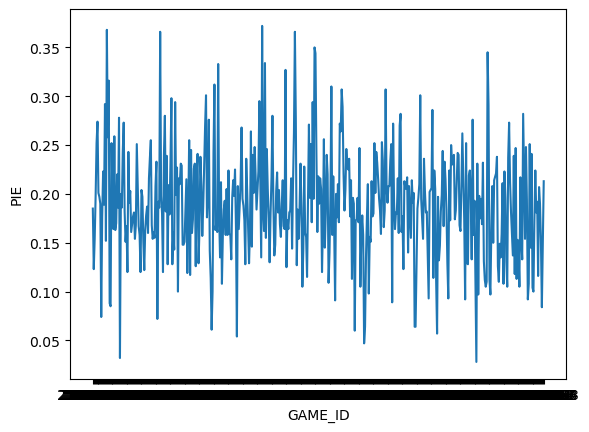

In [117]:
tmp_plot = df_boxscores[df_boxscores['PLAYER_ID'] == 2544]
sns.lineplot(x=tmp_plot['GAME_ID'].astype(str), y=tmp_plot['PIE'])
plt.show()

In [118]:
tmp_plot.shape

(483, 39)

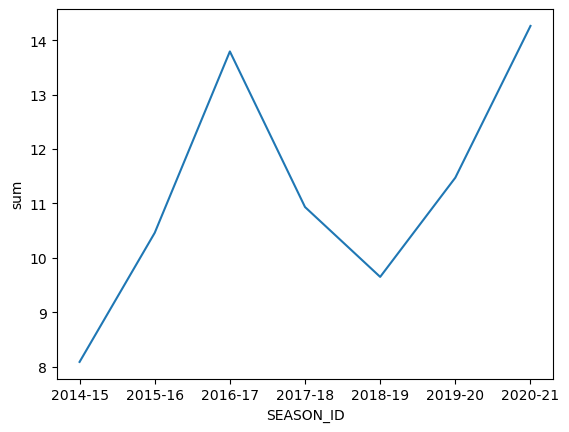

In [57]:
tmp_plot = tmp[tmp['PLAYER_ID'] == 101108].reset_index()
sns.lineplot(x=tmp_plot['SEASON_ID'], y=tmp_plot['sum'])
plt.show()

In [113]:
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia('en')
page_py = wiki_wiki.page('Chris Paul')

In [114]:
page_py.summary

'Christopher Emmanuel Paul (born May 6, 1985), nicknamed "CP3", is an American professional basketball player who plays for the Phoenix Suns of the National Basketball Association (NBA). Playing the point guard position, he has won the NBA Rookie of the Year Award, an NBA All-Star Game Most Valuable Player Award, two Olympic gold medals, and led the NBA in assists four times and steals a record six times. He has also been selected to eleven NBA All-Star teams, ten All-NBA teams, and nine NBA All-Defensive teams. In 2021, Paul was included in the NBA 75th Anniversary Team.\nPaul was a McDonald\'s All-American in high school before attending Wake Forest University for two years of college basketball, where he helped the Demon Deacons achieve their first-ever number-one ranking. He was selected fourth overall in the 2005 NBA draft by the New Orleans Hornets, where he developed into one of the league\'s premier players, finishing second in NBA Most Valuable Player Award voting in 2008. Dur

In [306]:
# df_boxscores = pd.read_csv(data_path + "boxscores_20_21.csv")
team_game_pie = df_boxscores.groupby(['GAME_ID', 'TEAM_ID', 'START_POSITION'])['PIE'].agg('sum')
team_game_pie = team_game_pie.reset_index()

In [314]:
team_game_pie = team_game_pie.pivot(index=['GAME_ID', 'TEAM_ID'], columns='START_POSITION', values='PIE').reset_index()

In [315]:
team_game_pie

START_POSITION,GAME_ID,TEAM_ID,C,F,G
0,21400001,1610612740,0.189,0.407,0.117
1,21400001,1610612753,0.271,0.211,0.039
2,21400002,1610612742,0.089,0.167,0.254
3,21400002,1610612759,-0.079,0.346,0.205
4,21400003,1610612745,0.147,0.333,0.426
...,...,...,...,...,...
16573,22001078,1610612759,0.128,0.256,0.092
16574,22001079,1610612754,0.171,0.270,0.150
16575,22001079,1610612761,0.119,0.104,0.177
16576,22001080,1610612764,0.000,0.169,0.236


In [317]:
# df_schedule = pd.read_csv(data_path + "schedule_20_21.csv")
team_game_diff = df_schedule['PLUS_MINUS']

In [320]:
df_merge = pd.merge(team_game_pie, df_schedule, how="left")
df_merge[['C_log', 'F_log', 'G_log']] = np.log1p(df_merge[['C', 'F', 'G']])

In [321]:
df_merge.shape # 16578 games?

(16578, 36)

In [322]:
df_merge['home_game'] = df_merge['MATCHUP'].apply(lambda x: False if x.find('@') != -1 else True)
df_merge['date'] = df_merge['GAME_DATE'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
df_merge['month'] = df_merge['date'].apply(lambda x: x.month)

In [323]:
# df_merge = df_merge[(df_merge['PIE'] > -1) & (df_merge['PIE'] < 4)]
# df_merge = df_merge[~df_merge['PIE_log'].isna()]
df_merge['PLUS_MINUS'] = df_merge['PLUS_MINUS']

In [324]:
df_merge

,GAME_ID,TEAM_ID,C,F,G,Unnamed: 0,SEASON_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,...,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,C_log,F_log,G_log,home_game,date,month
0,21400001,1610612740,0.189,0.407,0.117,4,2014-15,NOP,New Orleans Pelicans,2014-10-28,...,17,101,17,1,0.173113,0.341460,0.110647,True,2014-10-28,10
1,21400001,1610612753,0.271,0.211,0.039,5,2014-15,ORL,Orlando Magic,2014-10-28,...,25,84,-17,1,0.239804,0.191446,0.038259,False,2014-10-28,10
2,21400002,1610612742,0.089,0.167,0.254,0,2014-15,DAL,Dallas Mavericks,2014-10-28,...,20,100,-1,1,0.085260,0.154436,0.226338,False,2014-10-28,10
3,21400002,1610612759,-0.079,0.346,0.205,1,2014-15,SAS,San Antonio Spurs,2014-10-28,...,20,101,1,1,-0.082295,0.297137,0.186480,True,2014-10-28,10
4,21400003,1610612745,0.147,0.333,0.426,3,2014-15,HOU,Houston Rockets,2014-10-28,...,30,108,18,1,0.137150,0.287432,0.354873,False,2014-10-28,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,22001078,1610612759,0.128,0.256,0.092,2135,2019-20,SAS,San Antonio Spurs,2021-05-16,...,8,121,-2,1,0.120446,0.227932,0.088011,True,2021-05-16,5
16574,22001079,1610612754,0.171,0.270,0.150,2154,2019-20,IND,Indiana Pacers,2021-05-16,...,19,125,12,1,0.157858,0.239017,0.139762,False,2021-05-16,5
16575,22001079,1610612761,0.119,0.104,0.177,2155,2019-20,TOR,Toronto Raptors,2021-05-16,...,12,113,-12,1,0.112435,0.098940,0.162969,True,2021-05-16,5
16576,22001080,1610612764,0.000,0.169,0.236,2152,2019-20,WAS,Washington Wizards,2021-05-16,...,20,115,5,1,0.000000,0.156149,0.211880,True,2021-05-16,5


In [325]:
df_merge[~(df_merge['home_game'])]['TEAM_ID']

1        1610612753
2        1610612742
4        1610612745
6        1610612749
9        1610612755
            ...    
16568    1610612743
16571    1610612762
16572    1610612756
16574    1610612754
16577    1610612766
Name: TEAM_ID, Length: 8289, dtype: int64

In [326]:
df_merge.shape

(16578, 39)

In [341]:
# data dictionary - PLUS_MINUS from home-team's perspective
data_dict = {'GAME_ID':df_merge['GAME_ID'].unique(),
             'SEASON_ID':df_merge[df_merge['home_game']]['SEASON_ID'],
             'HOME_ID':df_merge[df_merge['home_game']]['TEAM_ID'].to_numpy(),
             'AWAY_ID':df_merge[~(df_merge['home_game'])]['TEAM_ID'].to_numpy(),
             
             'HOME_PIE_G':df_merge[df_merge['home_game']]['G'].to_numpy(), 
             'AWAY_PIE_G':df_merge[~(df_merge['home_game'])]['G'].to_numpy(),
             'HOME_PIE_G_log':df_merge[(df_merge['home_game'])]['G_log'].to_numpy(),
             'AWAY_PIE_G_log':df_merge[~(df_merge['home_game'])]['G_log'].to_numpy(),
             
             'HOME_PIE_F':df_merge[df_merge['home_game']]['F'].to_numpy(), 
             'AWAY_PIE_F':df_merge[~(df_merge['home_game'])]['F'].to_numpy(),
             'HOME_PIE_F_log':df_merge[(df_merge['home_game'])]['F_log'].to_numpy(),
             'AWAY_PIE_F_log':df_merge[~(df_merge['home_game'])]['F_log'].to_numpy(),
             
             'HOME_PIE_C':df_merge[df_merge['home_game']]['C'].to_numpy(), 
             'AWAY_PIE_C':df_merge[~(df_merge['home_game'])]['C'].to_numpy(),
             'HOME_PIE_C_log':df_merge[(df_merge['home_game'])]['C_log'].to_numpy(),
             'AWAY_PIE_C_log':df_merge[~(df_merge['home_game'])]['C_log'].to_numpy(),
             
             'month':df_merge[df_merge['home_game']]['month'].to_numpy(), 
             'HOME_PLUS_MINUS':df_merge[(df_merge['home_game'])]['PLUS_MINUS'].to_numpy(), 
             'AWAY_PLUS_MINUS':df_merge[~(df_merge['home_game'])]['PLUS_MINUS'].to_numpy(),
             'HOME_PTS':df_merge[(df_merge['home_game'])]['PTS'].to_numpy(), 
             'AWAY_PTS':df_merge[~(df_merge['home_game'])]['PTS'].to_numpy()}

# one row is one game!
df_model = pd.DataFrame(data=data_dict)

In [342]:
df_model.shape

(8289, 21)

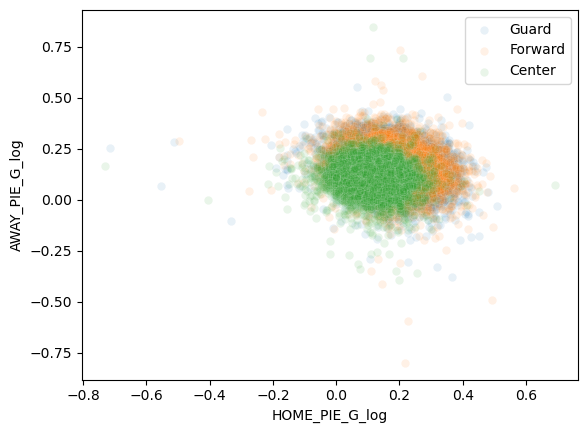

In [336]:
# tighter plot for centers, because there is only one?
sns.scatterplot(data=df_model, x='HOME_PIE_G_log', y='AWAY_PIE_G_log', label="Guard", alpha=0.1)
sns.scatterplot(data=df_model, x='HOME_PIE_F_log', y='AWAY_PIE_F_log', label="Forward", alpha=0.1)
sns.scatterplot(data=df_model, x='HOME_PIE_C_log', y='AWAY_PIE_C_log', label="Center", alpha=0.1)

plt.legend()

plt.show()

## Remove Outliers

In [368]:
df_model = df_model.replace([np.inf, -np.inf], np.nan)
df_model = df_model.dropna()
df_model = df_model[~pd.isnull(df_model)]

In [369]:
df_model['AWAY_PIE_G_log'].max()

0.5510074133988225

In [370]:
PIE_cols = ['HOME_PIE_G_log', 'AWAY_PIE_G_log', 'HOME_PIE_F_log', 'AWAY_PIE_F_log', 'HOME_PIE_C_log', 'AWAY_PIE_C_log']

In [371]:
df_model[PIE_cols].describe()

,HOME_PIE_G_log,AWAY_PIE_G_log,HOME_PIE_F_log,AWAY_PIE_F_log,HOME_PIE_C_log,AWAY_PIE_C_log
count,8287.000000,8287.000000,8287.000000,8287.000000,8287.000000,8287.000000
mean,0.186975,0.173323,0.180913,0.168562,0.116615,0.107301
std,0.083611,0.083235,0.085583,0.086920,0.066472,0.067983
min,-0.715393,-0.376878,-0.497580,-0.798508,-0.731888,-0.394525
25%,0.136278,0.123102,0.127513,0.116894,0.076035,0.067659
50%,0.190620,0.175633,0.181488,0.170586,0.117783,0.108854
75%,0.241376,0.228728,0.236652,0.224742,0.159565,0.149282
max,0.509825,0.551007,0.563038,0.731406,0.693147,0.847155


In [372]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=10)
outlier = clf.fit_predict(df_model[PIE_cols])

In [374]:
df_tmp = df_model[outlier == 1]

In [375]:
df_model.shape[0] - df_tmp.shape[0]

172

In [376]:
df_model = df_tmp

In [377]:
df_model.shape

(8115, 21)

In [378]:
df_model.groupby(['SEASON_ID']).count()

,GAME_ID,HOME_ID,AWAY_ID,HOME_PIE_G,AWAY_PIE_G,HOME_PIE_G_log,AWAY_PIE_G_log,HOME_PIE_F,AWAY_PIE_F,HOME_PIE_F_log,AWAY_PIE_F_log,HOME_PIE_C,AWAY_PIE_C,HOME_PIE_C_log,AWAY_PIE_C_log,month,HOME_PLUS_MINUS,AWAY_PLUS_MINUS,HOME_PTS,AWAY_PTS
SEASON_ID,,,,,,,,,,,,,,,,,,,,
2014-15,1196,1196,1196,1196,1196,1196,1196,1196,1196,1196,1196,1196,1196,1196,1196,1196,1196,1196,1196,1196
2015-16,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203,1203
2016-17,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036,1036
2017-18,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205
2018-19,1195,1195,1195,1195,1195,1195,1195,1195,1195,1195,1195,1195,1195,1195,1195,1195,1195,1195,1195,1195
2019-20,1068,1068,1068,1068,1068,1068,1068,1068,1068,1068,1068,1068,1068,1068,1068,1068,1068,1068,1068,1068
2020-21,1212,1212,1212,1212,1212,1212,1212,1212,1212,1212,1212,1212,1212,1212,1212,1212,1212,1212,1212,1212


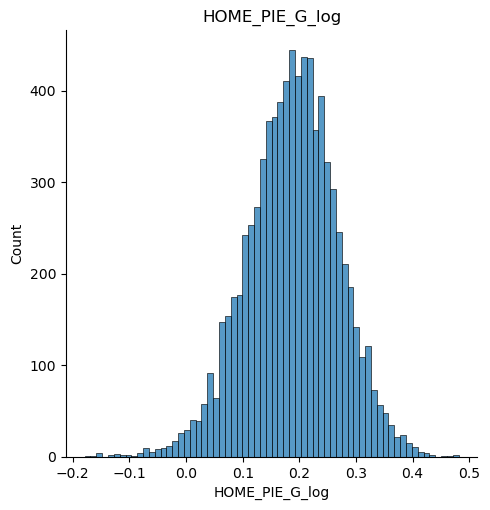

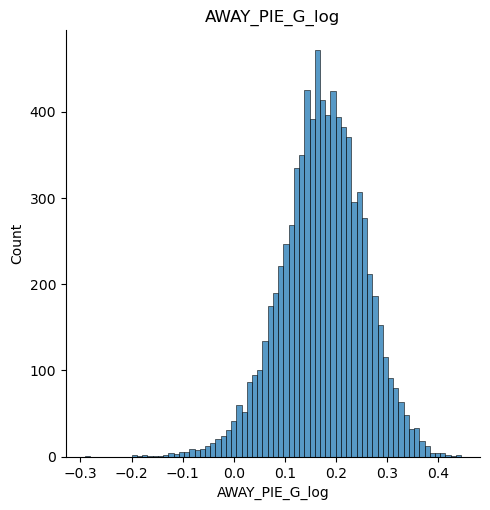

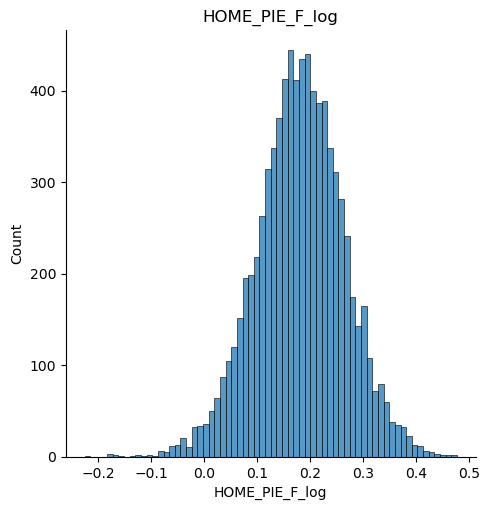

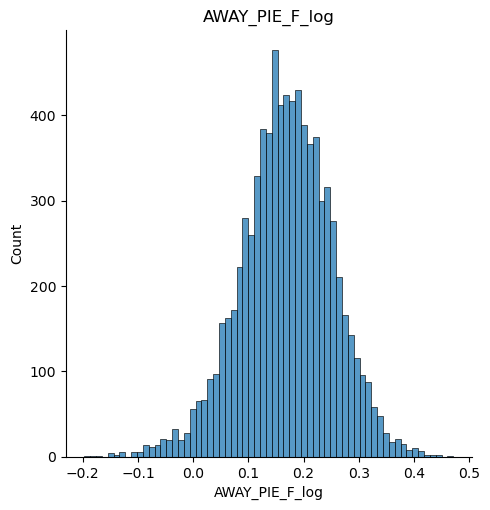

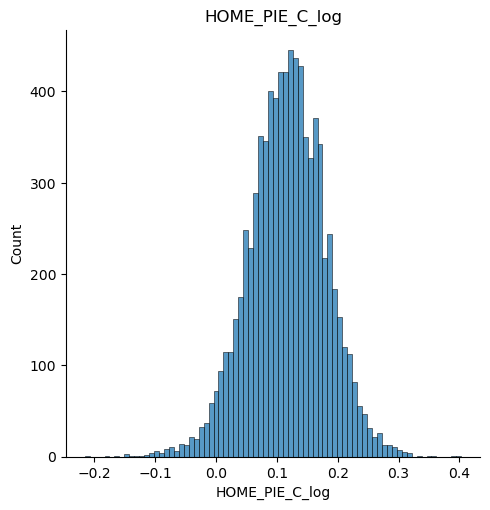

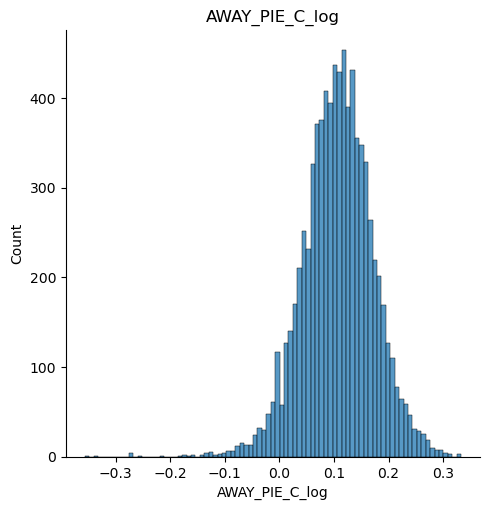

In [380]:
for pie in PIE_cols:
    sns.displot(data=df_model, x=pie)
    plt.title(pie)
    
plt.show()

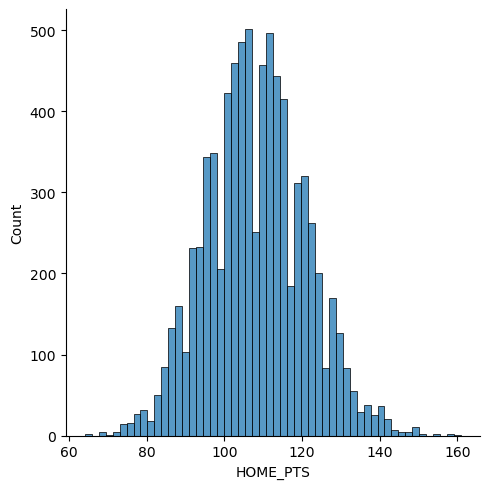

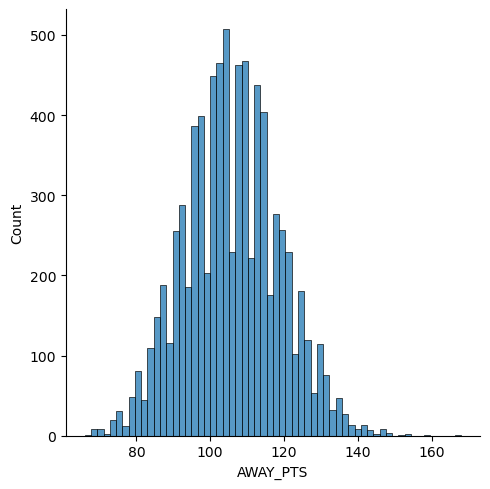

In [269]:
sns.displot(data=df_model, x='HOME_PTS')
sns.displot(data=df_model, x='AWAY_PTS')
plt.show()

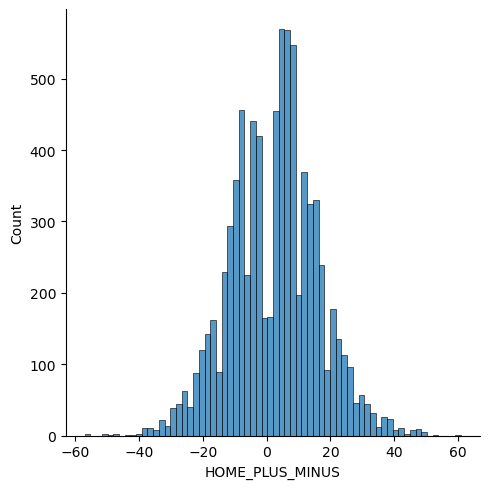

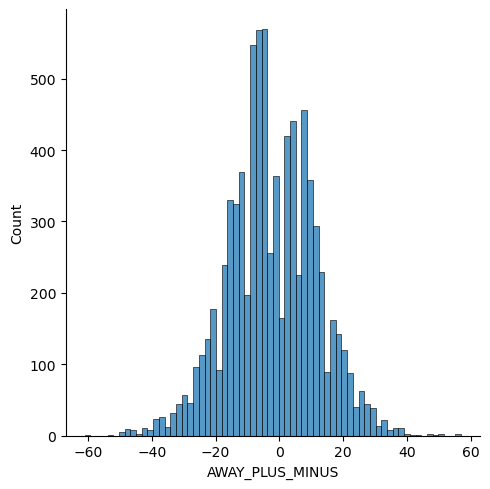

In [381]:
sns.displot(data=df_model, x='HOME_PLUS_MINUS')
sns.displot(data=df_model, x='AWAY_PLUS_MINUS')
plt.show()

## Keep in mind the axis label: x-axis is PIE_log, not specific to home or away!

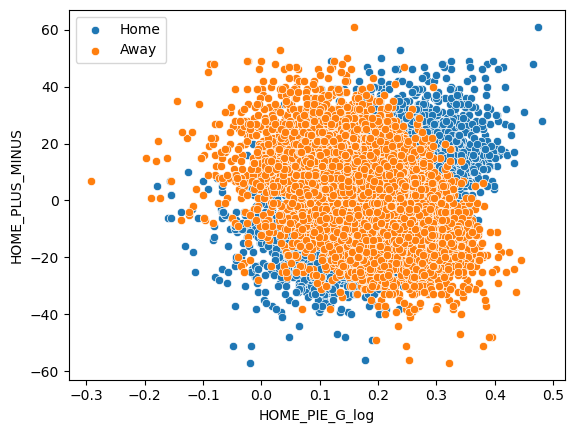

In [385]:
sns.scatterplot(data=df_model, x='HOME_PIE_G_log', y='HOME_PLUS_MINUS', label="Home")
sns.scatterplot(data=df_model, x='AWAY_PIE_G_log', y='HOME_PLUS_MINUS', label="Away")
plt.legend()
plt.show()

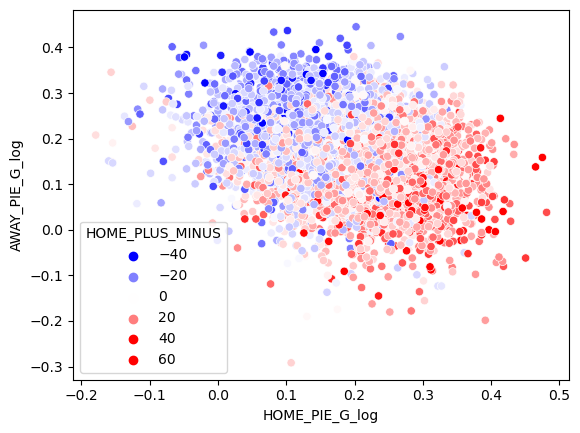

In [389]:
sns.scatterplot(data=df_model, x='HOME_PIE_G_log', y='AWAY_PIE_G_log', hue='HOME_PLUS_MINUS', palette='bwr', hue_norm=(-40,40))
plt.show()

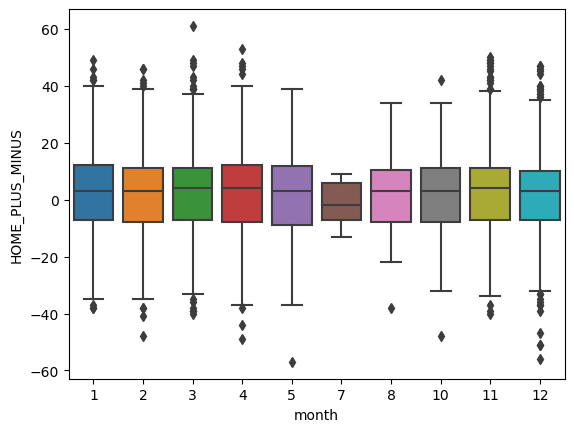

In [390]:
sns.boxplot(data=df_model, x='month', y='HOME_PLUS_MINUS')
plt.show()

## Week of the Season as a variable, Game of the team, Interaction with team strength

For validation, to train test split despite bayesian approach

In [391]:
train = df_model[~(df_model['SEASON_ID'] == '2020-21')]
test = df_model[df_model['SEASON_ID'] == '2020-21']

In [392]:
assert df_model.shape[0] == (train.shape[0] + test.shape[0])

In [393]:
from pymc3 import HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample

In [396]:
df_bmb = train.dropna()
test_bmb = test.dropna()

In [461]:
formula = "HOME_PLUS_MINUS ~ HOME_PIE_G_log + HOME_PIE_F_log + HOME_PIE_C_log + AWAY_PIE_G_log + AWAY_PIE_F_log + AWAY_PIE_C_log + month"

In [462]:
model = bmb.Model(formula, df_bmb)
trace = model.fit(draws=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [HOME_PLUS_MINUS_sigma, Intercept, month, AWAY_PIE_C_log, AWAY_PIE_F_log, AWAY_PIE_G_log, HOME_PIE_C_log, HOME_PIE_F_log, HOME_PIE_G_log]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 38 seconds.


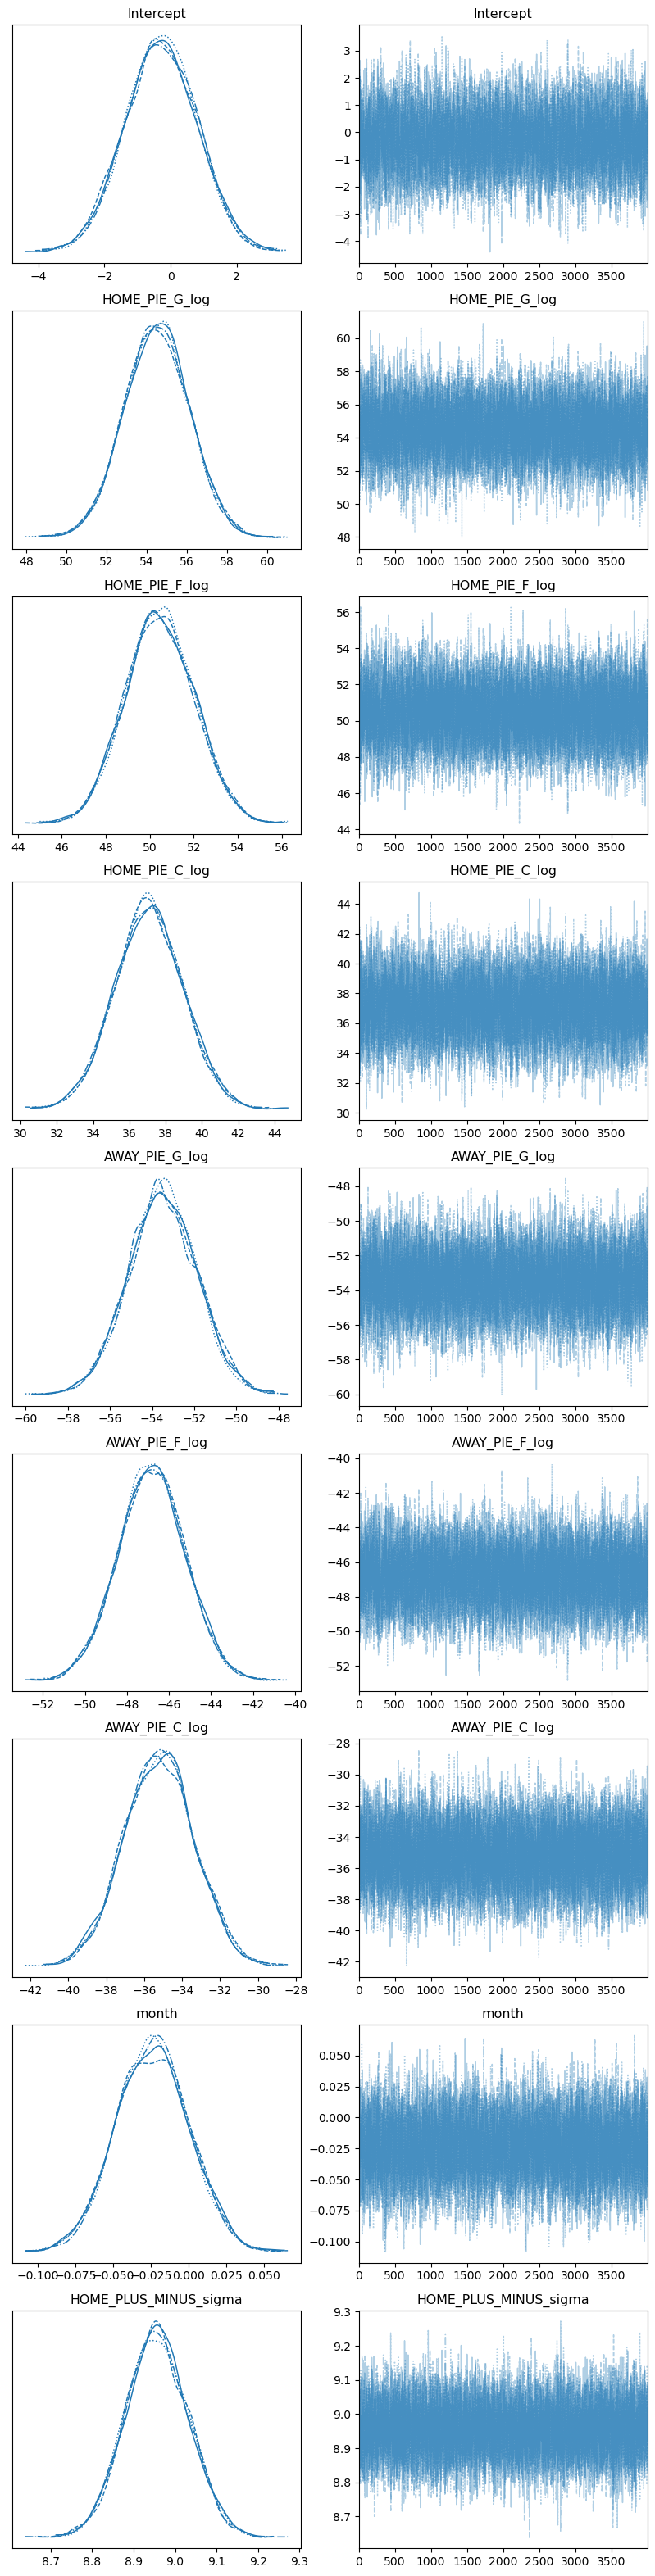

In [463]:
az.plot_trace(trace, figsize=(10, 40), compact=True)
plt.show()

In [464]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.290,1.082,-2.359,1.683,0.013,0.010,6527.0,8308.0,1.0
HOME_PIE_G_log,54.490,1.615,51.458,57.512,0.016,0.012,9833.0,11253.0,1.0
HOME_PIE_F_log,50.451,1.560,47.520,53.342,0.016,0.011,9782.0,10918.0,1.0
HOME_PIE_C_log,37.079,1.881,33.588,40.697,0.018,0.013,10849.0,11809.0,1.0
AWAY_PIE_G_log,-53.493,1.637,-56.698,-50.528,0.016,0.012,9878.0,11219.0,1.0
AWAY_PIE_F_log,-46.820,1.583,-49.722,-43.735,0.016,0.011,10392.0,12167.0,1.0
AWAY_PIE_C_log,-35.212,1.840,-38.711,-31.797,0.016,0.011,13285.0,12469.0,1.0
month,-0.024,0.024,-0.067,0.023,0.000,0.000,13560.0,12208.0,1.0
HOME_PLUS_MINUS_sigma,8.956,0.076,8.816,9.099,0.001,0.000,20053.0,13329.0,1.0


In [465]:
model.predict(trace, data=test_bmb) # simulation season 2020-21

In [466]:
# Compute mean across chains
posterior_mean = trace.posterior["HOME_PLUS_MINUS_mean"].values.mean(0)
posterior_mean.shape

(4000, 1212)

## Outliers make a large difference for regression!

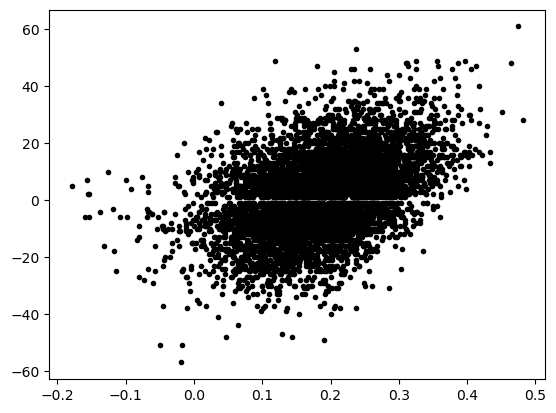

In [467]:
#plt.plot(df_bmb['HOME_PIE_log'], posterior_mean.T, color="lightgray", alpha=0.005)
plt.plot(df_bmb['HOME_PIE_G_log'], df_bmb['HOME_PLUS_MINUS'], '.', color="black")
plt.show()

In [529]:
# calculate mean function
predicted_mean = posterior_mean.mean(axis=0)
true_mean = test_bmb['HOME_PLUS_MINUS']

# init binary arrays
predicted_binary = np.zeros(predicted_mean.shape)
predicted_binary_away = np.zeros(predicted_mean.shape)

true_binary = np.zeros(predicted_mean.shape)
true_binary_away = np.zeros(predicted_mean.shape)

In [530]:
# code wins and losses of prediction
predicted_binary[predicted_mean > 0] = 1
predicted_binary[predicted_mean < 0] = 0

predicted_binary_away[predicted_mean > 0] = 0
predicted_binary_away[predicted_mean < 0] = 1

In [531]:
# code wins and losses of true observations
true_binary[test_bmb['HOME_PLUS_MINUS'] > 0] = 1
true_binary[test_bmb['HOME_PLUS_MINUS'] < 0] = 0

true_binary_away[test_bmb['HOME_PLUS_MINUS'] > 0] = 0
true_binary_away[test_bmb['HOME_PLUS_MINUS'] < 0] = 1

In [532]:
from sklearn.metrics import mean_squared_error, accuracy_score

print(f' RMSE: {np.round(np.sqrt(mean_squared_error(y_true=true_mean, y_pred=predicted_mean)), 2)} PTS of deviation')
print(f' Accuracy: {np.round(accuracy_score(y_true=true_binary, y_pred=predicted_binary) * 100, 2)} percent of games correctly classified')

 RMSE: 9.16 PTS of deviation
 Accuracy: 81.77 percent of games correctly classified


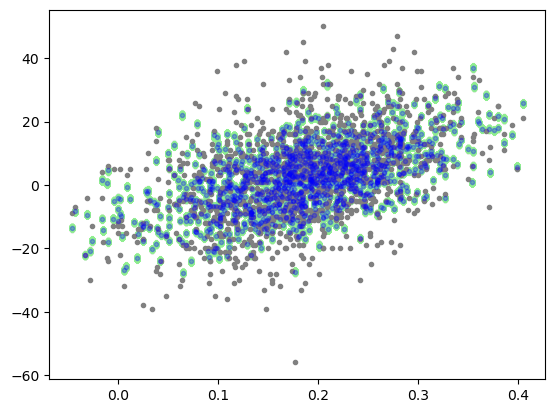

In [497]:
plt.plot(test_bmb['HOME_PIE_G_log'], posterior_mean.T, '.', alpha=0.05, color="lightgreen")
plt.plot(test_bmb['HOME_PIE_G_log'], test_bmb['HOME_PLUS_MINUS'], '.', color="grey")
plt.plot(test_bmb['HOME_PIE_G_log'], predicted_mean, '.', alpha=0.3, color="blue")

plt.show()

In [533]:
test_bmb['HOME_WIN_PRED'] = predicted_binary
test_bmb['AWAY_WIN_PRED'] = predicted_binary_away

test_bmb['HOME_WIN_TRUE'] = true_binary
test_bmb['AWAY_WIN_TRUE'] = true_binary_away

In [534]:
home_wins = test_bmb.groupby(['HOME_ID'])[['HOME_WIN_PRED', 'HOME_WIN_TRUE']].sum().reset_index().rename(columns={'HOME_ID':'TEAM_ID'})
away_wins = test_bmb.groupby(['AWAY_ID'])[['AWAY_WIN_PRED', 'AWAY_WIN_TRUE']].sum().reset_index().rename(columns={'AWAY_ID':'TEAM_ID'})

In [535]:
scoreboard = pd.merge(home_wins, away_wins)

In [585]:
scoreboard['WIN_PRED'] = scoreboard['HOME_WIN_PRED'] + scoreboard['AWAY_WIN_PRED']
scoreboard['WIN_TRUE'] = scoreboard['HOME_WIN_TRUE'] + scoreboard['AWAY_WIN_TRUE']
scoreboard['MSE'] = (scoreboard['WIN_PRED'] - scoreboard['WIN_TRUE'])**2
scoreboard['MAE'] = np.abs(scoreboard['WIN_PRED'] - scoreboard['WIN_TRUE'])

In [586]:
from nba_api.stats.static import teams

# get_players returns a list of dictionaries, each representing a player.
nba_teams = pd.DataFrame(teams.get_teams())
nba_teams = nba_teams.rename(columns={'id':'TEAM_ID'})

In [587]:
eastern_conference = [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]

In [588]:
nba_teams['eastern_conf'] = eastern_conference
nba_teams['eastern_conf'] = nba_teams['eastern_conf'].astype(bool)

nba_teams.to_csv("./data/data_assets/teams.csv")

In [589]:
scoreboard = pd.merge(scoreboard, nba_teams)

In [593]:
scoreboard_present = scoreboard[['full_name', 'TEAM_ID', 'eastern_conf', 'WIN_PRED', 'WIN_TRUE', 'MSE', 'MAE']]

scoreboard_present_east = scoreboard_present[scoreboard_present['eastern_conf']]
scoreboard_present_west = scoreboard_present[~scoreboard_present['eastern_conf']]

For this season, the model leads 6/8 playoff contenders for the east and the west. However, there are some surprising seasons (see high MSE)

In [594]:
# it is the 2018-19 season, self-created identifiers are wrong!
scoreboard_present_east.sort_values(by=['WIN_PRED'], ascending=False).reset_index()

,index,full_name,TEAM_ID,eastern_conf,WIN_PRED,WIN_TRUE,MSE,MAE
0,12,Milwaukee Bucks,1610612749,True,65.0,60.0,25.0,5.0
1,24,Toronto Raptors,1610612761,True,62.0,58.0,16.0,4.0
2,1,Boston Celtics,1610612738,True,49.0,49.0,0.0,0.0
3,17,Indiana Pacers,1610612754,True,48.0,48.0,0.0,0.0
4,18,Philadelphia 76ers,1610612755,True,45.0,48.0,9.0,3.0
5,29,Charlotte Hornets,1610612766,True,45.0,39.0,36.0,6.0
6,16,Orlando Magic,1610612753,True,44.0,41.0,9.0,3.0
7,11,Miami Heat,1610612748,True,36.0,38.0,4.0,2.0
8,27,Washington Wizards,1610612764,True,34.0,32.0,4.0,2.0
9,14,Brooklyn Nets,1610612751,True,33.0,41.0,64.0,8.0


In [595]:
scoreboard_present_west.sort_values(by=['WIN_PRED'], ascending=False).reset_index()

,index,full_name,TEAM_ID,eastern_conf,WIN_PRED,WIN_TRUE,MSE,MAE
0,7,Golden State Warriors,1610612744,False,65.0,57.0,64.0,8.0
1,8,Houston Rockets,1610612745,False,53.0,53.0,0.0,0.0
2,25,Utah Jazz,1610612762,False,53.0,49.0,16.0,4.0
3,20,Portland Trail Blazers,1610612757,False,50.0,52.0,4.0,2.0
4,3,New Orleans Pelicans,1610612740,False,48.0,33.0,225.0,15.0
5,6,Denver Nuggets,1610612743,False,45.0,54.0,81.0,9.0
6,23,Oklahoma City Thunder,1610612760,False,43.0,49.0,36.0,6.0
7,10,Los Angeles Lakers,1610612747,False,42.0,36.0,36.0,6.0
8,22,San Antonio Spurs,1610612759,False,42.0,48.0,36.0,6.0
9,13,Minnesota Timberwolves,1610612750,False,37.0,35.0,4.0,2.0


/Users/hoener/opt/anaconda3/envs/ds/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


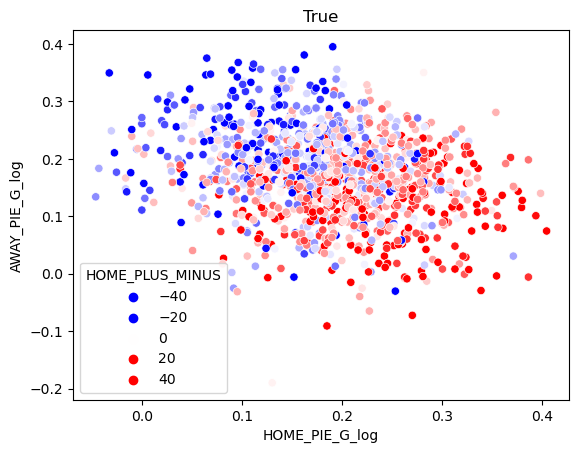

In [486]:
sns.scatterplot(test_bmb['HOME_PIE_G_log'], test_bmb['AWAY_PIE_G_log'], hue=test_bmb['HOME_PLUS_MINUS'], palette='bwr', hue_norm=(-20,20))
plt.title("True")

plt.show()

/Users/hoener/opt/anaconda3/envs/ds/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


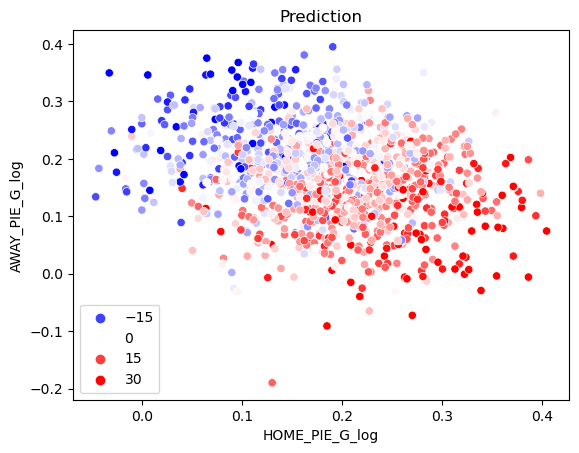

In [489]:
sns.scatterplot(test_bmb['HOME_PIE_G_log'], test_bmb['AWAY_PIE_G_log'], hue=posterior_mean[0,:].flatten(), palette='bwr', hue_norm=(-20,20))
plt.title("Prediction")

plt.show()

# Skellam
As a first approach, we could use the average PTS scored of Home / Away teams as the respective lambdas in the Skellam distribution!
[tutorial](https://discourse.pymc.io/t/modeling-count-differences-skellam-distribution/185/3)

In [633]:
mu_home = df_model['HOME_PTS'].mean()
sig_home = df_model['HOME_PTS'].std()
mu_away = df_model['AWAY_PTS'].mean()
sig_away = df_model['AWAY_PTS'].std()

In [634]:
from scipy.stats import skellam
Y = skellam.rvs(mu_away, mu_home)

In [635]:
import scipy
import theano
import pymc3
mu1_true, mu2_true = mu_away, mu_home
N = 200
X = pd.DataFrame({'constant':np.ones(N), 'var':np.random.normal(size=N)})
beta_true = pd.Series({'constant':25, 'var':20})
mu_true = np.dot(X, beta_true)
var_true = 120

# mu = m1-m2
# var = m1+m2

mu1_true = (var_true + mu_home)/2
mu2_true = (var_true - mu_away)/2

Y = scipy.stats.skellam.rvs(mu_home, mu_away, size=df_merge.shape[0])

In [636]:
df_plot = np.concatenate([Y.reshape(-1,1), df_merge['PLUS_MINUS'].to_numpy().reshape(-1,1)], axis=1)

In [637]:
df_plot.shape

(16578, 2)

> Besides the dent around zero, the two distributions are fairly close!

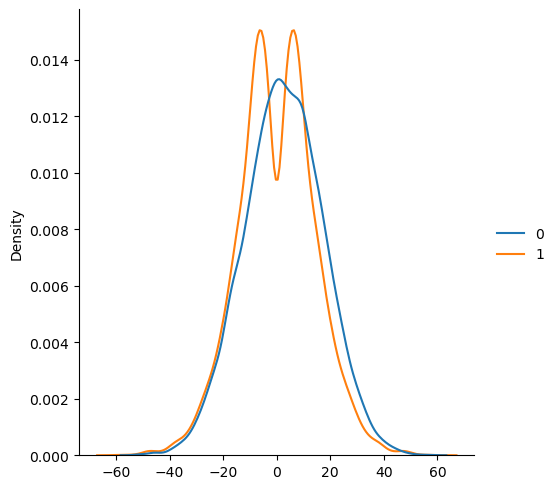

In [638]:
ax = sns.displot(df_plot, kind='kde')
plt.show()

In [639]:
# copied from theano master branch

from __future__ import absolute_import, print_function, division
# Definitions of theano.scalar ops that have their python implementation taken
# from SciPy. As SciPy is not always available, we treat them separately.

import numpy as np

import theano
from theano.gradient import grad_not_implemented
from theano.scalar.basic import (UnaryScalarOp, BinaryScalarOp,
                                 exp, upgrade_to_float,
                                 upgrade_to_float64,
                                 float_types)
from theano.scalar.basic import (upgrade_to_float_no_complex,
                                 complex_types, discrete_types,
                                 upcast)

imported_scipy_special = False
try:
    import scipy.special
    import scipy.stats
    imported_scipy_special = True
# Importing scipy.special may raise ValueError.
# See http://projects.scipy.org/scipy/ticket/1739
except (ImportError, ValueError):
    pass

class Iv(BinaryScalarOp):
    """
    Modified Bessel function of the first kind of order v (real).
    """

    @staticmethod
    def st_impl(v, x):
        return scipy.special.iv(v, x)

    def impl(self, v, x):
        if imported_scipy_special:
            return self.st_impl(v, x)
        else:
            super(Iv, self).impl(v, x)

    def grad(self, inputs, grads):
        v, x = inputs
        gz, = grads
        return [grad_not_implemented(self, 0, v),
                gz * (iv(v - 1, x) + iv(v + 1, x)) / 2.]

iv = Iv(upgrade_to_float, name='iv')

# added:
iv_tensor = theano.tensor.elemwise.Elemwise(iv)

In [640]:
N = df_bmb.shape[0]
X = pd.DataFrame({'constant':np.ones(N), 'HOME_pie':df_bmb['HOME_PIE_log'], 
                  'AWAY_pie':df_bmb['AWAY_PIE_log'], 'month':df_bmb['month']}) # PIE the input data

# Y = scipy.stats.skellam.rvs(mu1_true, mu2_true) # PLUS_MINUS the observed data
Y = df_bmb['HOME_PLUS_MINUS']

In [723]:
from scipy import stats

# use class, because nested function cannot be pickled
class skellam_log:
    def __init__(self, mu1, mu2):
        self.mu1 = mu1
        self.mu2 = mu2
    def __call__(self, k):
        total = (-mu1-mu2)+(theano.tensor.log(mu1)-theano.tensor.log(mu2))*k/2
        log_prob = total+ theano.tensor.log(iv_tensor(k, 2*theano.tensor.sqrt(mu1*mu2)))
        return log_prob
    def rand(self, point=None, size=None, **kwargs):
        return stats.skellam.rvs(size=size, mu1=self.mu1, mu2=self.mu2, **kwargs)

with pymc3.Model() as model:
    
    # distributions of regression parameters
    beta0 = pymc3.Normal('intercept', mu=0, sd=10)
    beta_home_pie = pymc3.Normal('slope_home', mu=30, sd=2)
    beta_away_pie = pymc3.Normal('slope_away', mu=-20, sd=2)
    beta_month = pymc3.Normal('slope_month', mu=0, sd=1)
    
    # mean function i.e. regression model
    mean = beta0*X['constant'] + beta_home_pie*X['HOME_pie'] + beta_away_pie*X['AWAY_pie'] # + beta_month*X['month']
    
    # distribution of variance parameter?
    var = pymc3.DiscreteUniform('var', lower=5, upper=15) # replace by sd in home / away scores
    
    mu1 = mu_home # replace by mu_home + sd_home
    mu2 = mu_away # replace by mu_home + sd_home
    
    #obs = pymc3.DensityDist('obs', skellam_log(mu_home, mu_away), observed=Y)
    obs = pymc3.DensityDist('obs', skellam_log(mu1, mu2), observed=Y, random=skellam_log(mu1, mu2).rand)
    
    trace = pymc3.sample(2000, tune=500, nuts={'target_accept':0.9}, cores=1) #- problem with pickle abc?
    ppc = pm.sample_posterior_predictive(trace)

<ipython-input-723-12ecfe08cc71>:35: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pymc3.sample(2000, tune=500, nuts={'target_accept':0.9}, cores=1) #- problem with pickle abc?
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [slope_month, slope_away, slope_home, intercept]
>Metropolis: [var]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 2 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [724]:
ppc['obs'].shape

(4000, 8223)

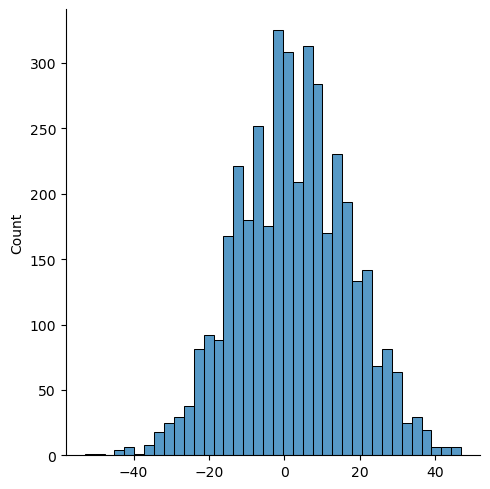

In [725]:
sns.displot(ppc['obs'][:,0])
plt.show()

> 4000 simulations of the first game in the data

In [726]:
X

,constant,HOME_pie,AWAY_pie,month
0,1.0,0.965843,0.980204,10
1,1.0,0.849296,0.745740,10
2,1.0,0.470628,0.973427,10
3,1.0,0.838978,0.973049,10
4,1.0,1.104594,0.569283,10
...,...,...,...,...
8284,1.0,1.066089,0.936877,5
8285,1.0,0.744315,1.051171,5
8286,1.0,0.997318,1.015955,5
8287,1.0,0.670390,0.862890,5


In [727]:
ppc['obs'].shape

(4000, 8223)

In [728]:
pred = ppc['obs']
pred_mean = pred.mean(axis=0)

In [729]:
pred_mean.shape

(8223,)

In [730]:
pred.mean(0)

array([2.366  , 2.19625, 2.09875, ..., 2.6635 , 2.23925, 2.23875])

/Users/hoener/opt/anaconda3/envs/ds/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


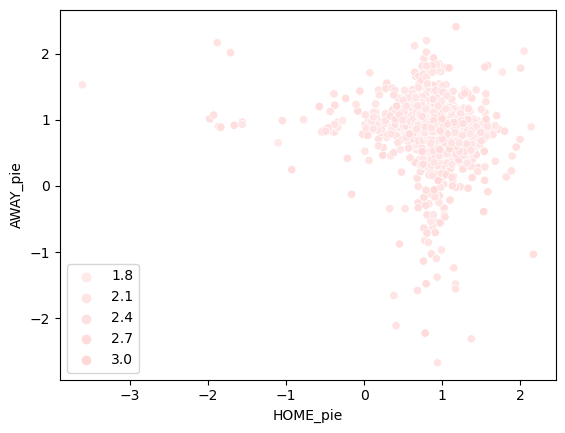

In [731]:
sns.scatterplot(X['HOME_pie'], X['AWAY_pie'], hue=pred.mean(0), palette='bwr', hue_norm=(-20,20))
plt.show()

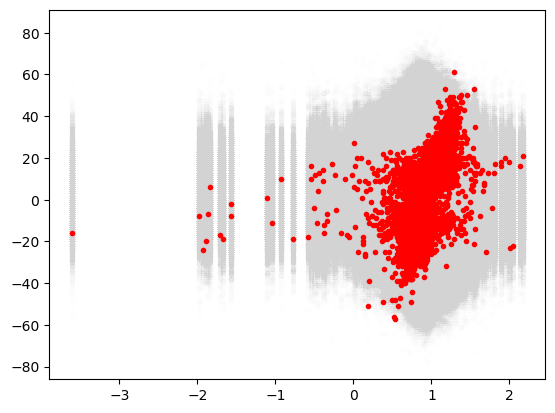

In [732]:
plt.plot(X['HOME_pie'], pred.T, '.', alpha=0.01, color="lightgray")
plt.plot(X['HOME_pie'], Y, '.', alpha=1, color="red")
plt.show()

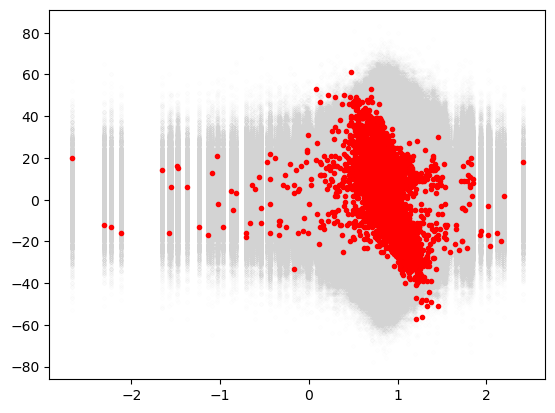

In [733]:
plt.plot(X['AWAY_pie'], pred.T, '.', alpha=0.005, color="lightgray")
plt.plot(X['AWAY_pie'], Y, '.', alpha=1, color="red")
plt.show()

In [720]:
plt.plot(X['month'], pred, '.', alpha=0.01, color="lightgray")
plt.plot(X['month'], Y, '.', alpha=1, color="red")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (8223,) and (4000, 8223)

Pickle Issue: Try specifying the backend differently! Standard is 'pickle'

pickle_backendstr
One of ‘pickle’ or ‘dill’. The library used to pickle models in parallel sampling if the multiprocessing context is not of type fork.

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/hoener/opt/anaconda3/envs/ds/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


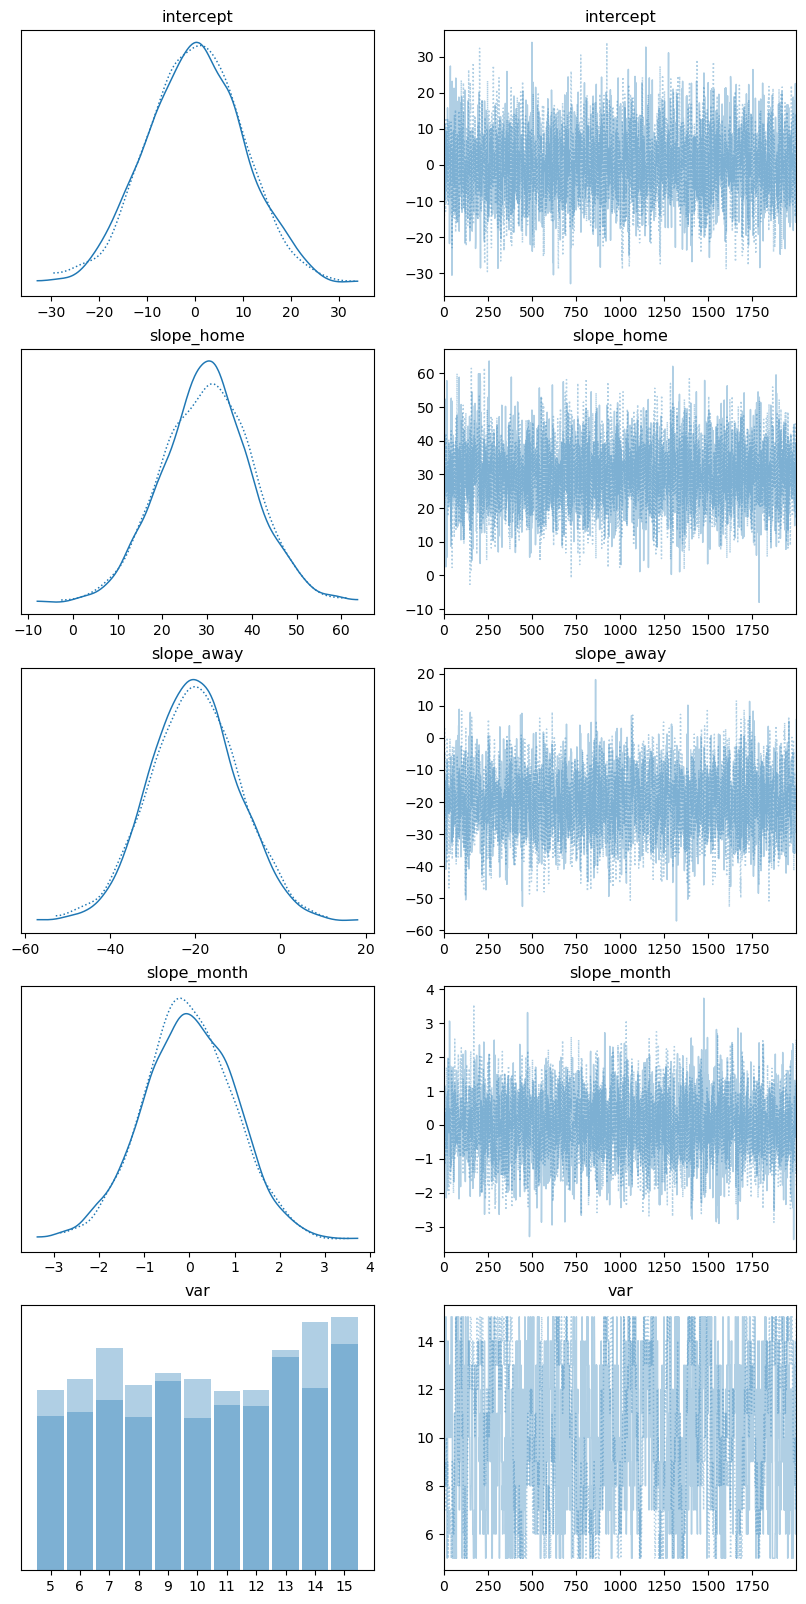

In [601]:
az.plot_trace(trace, figsize=(10, 20), compact=True)
plt.show()

<Figure size 1000x2000 with 0 Axes>

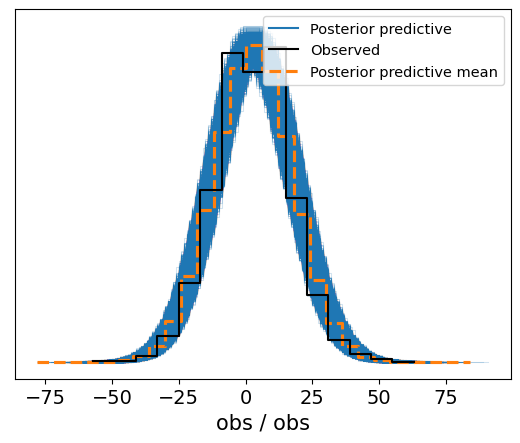

In [602]:
plt.figure(figsize=(10,20))
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))
plt.show()

## How does the simulation work now?
- Create a vector containing aggregated PIE's for each team, for each matchday
- Pass this vector to prediction (how does this work for the skellam model?)